In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO_075_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                  activation='relu')) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))         
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.75))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_DO_075_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,396,624
Trainable params: 16,396,624
Non-trainable params: 0
_________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 5333, 64)          12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 5333, 64)          12352     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3975 - acc: 0.2426
Epoch 00001: val_loss improved from inf to 2.20118, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_1_conv_checkpoint/001-2.2012.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 2.3975 - acc: 0.2427 - val_loss: 2.2012 - val_acc: 0.3380
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9784 - acc: 0.4061
Epoch 00002: val_loss improved from 2.20118 to 2.06752, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_1_conv_checkpoint/002-2.0675.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 1.9784 - acc: 0.4061 - val_loss: 2.0675 - val_acc: 0.3482
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6591 - acc: 0.5097
Epoch 00003: val_loss improved from 2.06752 to 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0867 - acc: 0.9807
Epoch 00028: val_loss did not improve from 2.01305
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.0867 - acc: 0.9807 - val_loss: 3.7958 - val_acc: 0.3776
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0828 - acc: 0.9825
Epoch 00029: val_loss did not improve from 2.01305
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.0828 - acc: 0.9825 - val_loss: 3.8466 - val_acc: 0.3741
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0750 - acc: 0.9838
Epoch 00030: val_loss did not improve from 2.01305
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.0750 - acc: 0.9838 - val_loss: 3.8884 - val_acc: 0.3753
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0749 - acc: 0.9845
Epoch 00031: val_loss did not improve from 2.01305
36805/36805 [========================

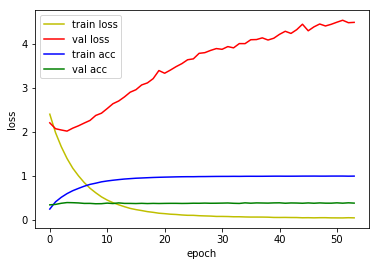

4815/4815 [==============================] - 2s 490us/sample - loss: 2.0562 - acc: 0.3641
Loss: 2.0561687808913236 Accuracy: 0.36407062

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2985 - acc: 0.2742
Epoch 00001: val_loss improved from inf to 2.00837, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_2_conv_checkpoint/001-2.0084.hdf5
36805/36805 [==============================] - 73s 2ms/sample - loss: 2.2985 - acc: 0.2743 - val_loss: 2.0084 - val_acc: 0.3860
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8164 - acc: 0.4527
Epoch 00002: val_loss improved from 2.00837 to 1.75839, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_2_conv_checkpoint/002-1.7584.hdf5
36805/36805 [==============================] - 73s 2ms/sample - loss: 1.8164 - acc: 0.4527 - val_loss: 1.7584 - val_acc: 0.4500
Epoch 3/500
36800/36805 [============================>

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1784 - acc: 0.9453
Epoch 00029: val_loss did not improve from 1.66007
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.1784 - acc: 0.9453 - val_loss: 2.7311 - val_acc: 0.4980
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1671 - acc: 0.9493
Epoch 00030: val_loss did not improve from 1.66007
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.1671 - acc: 0.9493 - val_loss: 2.8130 - val_acc: 0.5034
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1579 - acc: 0.9530
Epoch 00031: val_loss did not improve from 1.66007
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.1579 - acc: 0.9530 - val_loss: 2.7672 - val_acc: 0.5113
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1541 - acc: 0.9536
Epoch 00032: val_loss did not improve from 1.66007
36805/36805 [===========

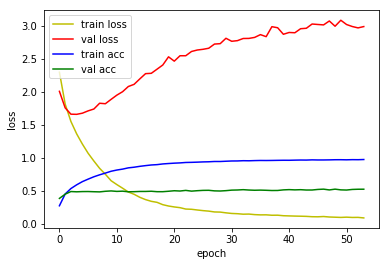

4815/4815 [==============================] - 4s 782us/sample - loss: 1.7243 - acc: 0.4665
Loss: 1.724294582061926 Accuracy: 0.46645898

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2363 - acc: 0.2932
Epoch 00001: val_loss improved from inf to 1.80666, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_3_conv_checkpoint/001-1.8067.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 2.2364 - acc: 0.2932 - val_loss: 1.8067 - val_acc: 0.4596
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6579 - acc: 0.4917
Epoch 00002: val_loss improved from 1.80666 to 1.51766, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_3_conv_checkpoint/002-1.5177.hdf5
36805/36805 [==============================] - 82s 2ms/sample - loss: 1.6579 - acc: 0.4916 - val_loss: 1.5177 - val_acc: 0.5236
Epoch 3/500
36800/36805 [============================>.

36800/36805 [============================>.] - ETA: 0s - loss: 0.2947 - acc: 0.9059
Epoch 00027: val_loss did not improve from 1.26386
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.2947 - acc: 0.9059 - val_loss: 1.4203 - val_acc: 0.6697
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2794 - acc: 0.9087
Epoch 00028: val_loss did not improve from 1.26386
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.2794 - acc: 0.9087 - val_loss: 1.4751 - val_acc: 0.6676
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2717 - acc: 0.9105
Epoch 00029: val_loss did not improve from 1.26386
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.2718 - acc: 0.9105 - val_loss: 1.4803 - val_acc: 0.6713
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2607 - acc: 0.9179
Epoch 00030: val_loss did not improve from 1.26386
36805/36805 [========================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1507 - acc: 0.9530
Epoch 00057: val_loss did not improve from 1.26386
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.1507 - acc: 0.9530 - val_loss: 1.5136 - val_acc: 0.6974

1D_CNN_custom_conv_3_VGG_DO_075_DO_3_conv Model


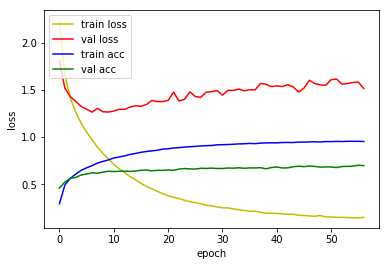

4815/4815 [==============================] - 4s 907us/sample - loss: 1.3509 - acc: 0.5850
Loss: 1.3508993964576523 Accuracy: 0.5850467

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3290 - acc: 0.2443
Epoch 00001: val_loss improved from inf to 1.79575, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_4_conv_checkpoint/001-1.7957.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.3289 - acc: 0.2444 - val_loss: 1.7957 - val_acc: 0.4060
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6060 - acc: 0.4776
Epoch 00002: val_loss improved from 1.79575 to 1.40597, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_4_conv_checkpoint/002-1.4060.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.6060 - acc: 0.4776 - val_loss: 1.4060 - val_acc: 0.5546
Epoch 3/500
36800/36805 [============================>.

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4030 - acc: 0.8692
Epoch 00024: val_loss did not improve from 0.77832
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.4029 - acc: 0.8692 - val_loss: 0.8028 - val_acc: 0.7787
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3905 - acc: 0.8725
Epoch 00025: val_loss did not improve from 0.77832
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.3905 - acc: 0.8725 - val_loss: 0.7788 - val_acc: 0.7845
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3819 - acc: 0.8763
Epoch 00026: val_loss did not improve from 0.77832
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.3820 - acc: 0.8763 - val_loss: 0.7850 - val_acc: 0.7822
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3663 - acc: 0.8815
Epoch 00027: val_loss improved from 0.77832 to 0.77662, saving model to mod

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2323 - acc: 0.9230
Epoch 00053: val_loss did not improve from 0.76814
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2323 - acc: 0.9229 - val_loss: 0.8038 - val_acc: 0.8064
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2220 - acc: 0.9267
Epoch 00054: val_loss did not improve from 0.76814
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2220 - acc: 0.9266 - val_loss: 0.7840 - val_acc: 0.8097
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2209 - acc: 0.9274
Epoch 00055: val_loss did not improve from 0.76814
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2209 - acc: 0.9274 - val_loss: 0.7793 - val_acc: 0.8162
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2146 - acc: 0.9290
Epoch 00056: val_loss did not improve from 0.76814
36805/36805 [===========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1663 - acc: 0.9440
Epoch 00083: val_loss did not improve from 0.76814
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.1663 - acc: 0.9440 - val_loss: 0.8166 - val_acc: 0.8185
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1680 - acc: 0.9454
Epoch 00084: val_loss did not improve from 0.76814
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.1680 - acc: 0.9454 - val_loss: 0.7969 - val_acc: 0.8220
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1712 - acc: 0.9431
Epoch 00085: val_loss did not improve from 0.76814
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.1712 - acc: 0.9431 - val_loss: 0.7896 - val_acc: 0.8272
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1657 - acc: 0.9443
Epoch 00086: val_loss did not improve from 0.76814
36805/36805 [===========

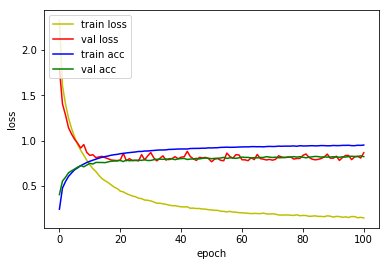

4815/4815 [==============================] - 5s 939us/sample - loss: 0.8876 - acc: 0.7697
Loss: 0.8876171379569658 Accuracy: 0.7696781

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3772 - acc: 0.2232
Epoch 00001: val_loss improved from inf to 1.65152, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_5_conv_checkpoint/001-1.6515.hdf5
36805/36805 [==============================] - 92s 3ms/sample - loss: 2.3772 - acc: 0.2232 - val_loss: 1.6515 - val_acc: 0.4582
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5650 - acc: 0.4908
Epoch 00002: val_loss improved from 1.65152 to 1.35204, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_5_conv_checkpoint/002-1.3520.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.5652 - acc: 0.4907 - val_loss: 1.3520 - val_acc: 0.5702
Epoch 3/500
36800/36805 [============================>.

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3912 - acc: 0.8789
Epoch 00024: val_loss did not improve from 0.54274
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.3912 - acc: 0.8789 - val_loss: 0.6195 - val_acc: 0.8262
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3820 - acc: 0.8805
Epoch 00025: val_loss did not improve from 0.54274
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.3820 - acc: 0.8805 - val_loss: 0.6001 - val_acc: 0.8379
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3701 - acc: 0.8848
Epoch 00026: val_loss did not improve from 0.54274
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.3700 - acc: 0.8848 - val_loss: 0.5498 - val_acc: 0.8502
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3610 - acc: 0.8875
Epoch 00027: val_loss did not improve from 0.54274
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.1952 - acc: 0.9353
Epoch 00053: val_loss did not improve from 0.53407
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1952 - acc: 0.9353 - val_loss: 0.5628 - val_acc: 0.8658
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1892 - acc: 0.9390
Epoch 00054: val_loss improved from 0.53407 to 0.53248, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_5_conv_checkpoint/054-0.5325.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1892 - acc: 0.9390 - val_loss: 0.5325 - val_acc: 0.8684
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1866 - acc: 0.9400
Epoch 00055: val_loss did not improve from 0.53248
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1866 - acc: 0.9400 - val_loss: 0.5706 - val_acc: 0.8630
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

36800/36805 [============================>.] - ETA: 0s - loss: 0.1310 - acc: 0.9584
Epoch 00082: val_loss did not improve from 0.53248
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1311 - acc: 0.9583 - val_loss: 0.5540 - val_acc: 0.8798
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1357 - acc: 0.9558
Epoch 00083: val_loss did not improve from 0.53248
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1357 - acc: 0.9558 - val_loss: 0.5566 - val_acc: 0.8803
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1309 - acc: 0.9577
Epoch 00084: val_loss did not improve from 0.53248
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1309 - acc: 0.9578 - val_loss: 0.5796 - val_acc: 0.8810
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1248 - acc: 0.9595
Epoch 00085: val_loss improved from 0.53248 to 0.52952, saving model to model/checkpoint

Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1087 - acc: 0.9649
Epoch 00111: val_loss did not improve from 0.52356
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1087 - acc: 0.9650 - val_loss: 0.5404 - val_acc: 0.8921
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1059 - acc: 0.9663
Epoch 00112: val_loss did not improve from 0.52356
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1059 - acc: 0.9663 - val_loss: 0.5617 - val_acc: 0.8891
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1030 - acc: 0.9677
Epoch 00113: val_loss did not improve from 0.52356
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1030 - acc: 0.9677 - val_loss: 0.5476 - val_acc: 0.8868
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1025 - acc: 0.9672
Epoch 00114: val_loss did not improve from 0.52356
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.0866 - acc: 0.9735
Epoch 00140: val_loss did not improve from 0.52088
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0866 - acc: 0.9735 - val_loss: 0.5761 - val_acc: 0.8868
Epoch 141/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0881 - acc: 0.9726
Epoch 00141: val_loss did not improve from 0.52088
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0880 - acc: 0.9726 - val_loss: 0.5520 - val_acc: 0.8894
Epoch 142/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0887 - acc: 0.9716
Epoch 00142: val_loss did not improve from 0.52088
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0887 - acc: 0.9716 - val_loss: 0.5614 - val_acc: 0.8959
Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0857 - acc: 0.9731
Epoch 00143: val_loss did not improve from 0.52088
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0759 - acc: 0.9763
Epoch 00169: val_loss did not improve from 0.51156
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0759 - acc: 0.9763 - val_loss: 0.5469 - val_acc: 0.8980
Epoch 170/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0762 - acc: 0.9766
Epoch 00170: val_loss did not improve from 0.51156
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0763 - acc: 0.9766 - val_loss: 0.5745 - val_acc: 0.8945
Epoch 171/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0808 - acc: 0.9751
Epoch 00171: val_loss did not improve from 0.51156
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0807 - acc: 0.9751 - val_loss: 0.5252 - val_acc: 0.9010
Epoch 172/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0717 - acc: 0.9776
Epoch 00172: val_loss did not improve from 0.51156
36805/36805 [=====================

Epoch 199/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0673 - acc: 0.9800
Epoch 00199: val_loss did not improve from 0.51156
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0673 - acc: 0.9800 - val_loss: 0.5693 - val_acc: 0.9019
Epoch 200/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0655 - acc: 0.9803
Epoch 00200: val_loss did not improve from 0.51156
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0655 - acc: 0.9803 - val_loss: 0.5479 - val_acc: 0.8959
Epoch 201/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0637 - acc: 0.9812
Epoch 00201: val_loss did not improve from 0.51156
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0637 - acc: 0.9812 - val_loss: 0.5669 - val_acc: 0.8991
Epoch 202/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0649 - acc: 0.9809
Epoch 00202: val_loss did not improve from 0.51156
36805/36805 [=======

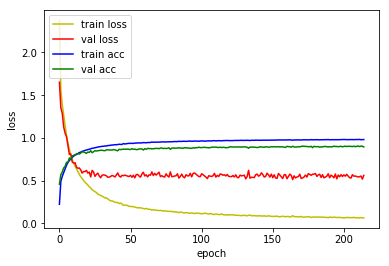

4815/4815 [==============================] - 5s 976us/sample - loss: 0.6308 - acc: 0.8706
Loss: 0.6307582460088522 Accuracy: 0.8706127

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4687 - acc: 0.1772
Epoch 00001: val_loss improved from inf to 1.81634, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_6_conv_checkpoint/001-1.8163.hdf5
36805/36805 [==============================] - 96s 3ms/sample - loss: 2.4685 - acc: 0.1773 - val_loss: 1.8163 - val_acc: 0.4253
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6874 - acc: 0.4425
Epoch 00002: val_loss improved from 1.81634 to 1.36578, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_6_conv_checkpoint/002-1.3658.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.6874 - acc: 0.4425 - val_loss: 1.3658 - val_acc: 0.5700
Epoch 3/500
36800/36805 [============================>.

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3936 - acc: 0.8804
Epoch 00023: val_loss improved from 0.34662 to 0.34633, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_6_conv_checkpoint/023-0.3463.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3935 - acc: 0.8805 - val_loss: 0.3463 - val_acc: 0.9071
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3777 - acc: 0.8859
Epoch 00024: val_loss did not improve from 0.34633
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3777 - acc: 0.8859 - val_loss: 0.3479 - val_acc: 0.9066
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3704 - acc: 0.8896
Epoch 00025: val_loss improved from 0.34633 to 0.33334, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_6_conv_checkpoint/025-0.3333.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3704 - acc: 0.

36800/36805 [============================>.] - ETA: 0s - loss: 0.2094 - acc: 0.9327
Epoch 00048: val_loss did not improve from 0.27818
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2095 - acc: 0.9327 - val_loss: 0.2800 - val_acc: 0.9257
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2088 - acc: 0.9332
Epoch 00049: val_loss did not improve from 0.27818
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2088 - acc: 0.9331 - val_loss: 0.2806 - val_acc: 0.9331
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2018 - acc: 0.9337
Epoch 00050: val_loss improved from 0.27818 to 0.27041, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_6_conv_checkpoint/050-0.2704.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2019 - acc: 0.9337 - val_loss: 0.2704 - val_acc: 0.9320
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

36800/36805 [============================>.] - ETA: 0s - loss: 0.1406 - acc: 0.9527
Epoch 00076: val_loss did not improve from 0.25932
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1406 - acc: 0.9527 - val_loss: 0.3108 - val_acc: 0.9336
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1295 - acc: 0.9568
Epoch 00077: val_loss did not improve from 0.25932
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1295 - acc: 0.9568 - val_loss: 0.2615 - val_acc: 0.9350
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1297 - acc: 0.9565
Epoch 00078: val_loss did not improve from 0.25932
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1297 - acc: 0.9566 - val_loss: 0.2849 - val_acc: 0.9336
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1298 - acc: 0.9573
Epoch 00079: val_loss improved from 0.25932 to 0.25898, saving model to model/checkpoint

36800/36805 [============================>.] - ETA: 0s - loss: 0.0970 - acc: 0.9677
Epoch 00105: val_loss did not improve from 0.25898
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0969 - acc: 0.9677 - val_loss: 0.3062 - val_acc: 0.9352
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0954 - acc: 0.9679
Epoch 00106: val_loss did not improve from 0.25898
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0955 - acc: 0.9679 - val_loss: 0.2965 - val_acc: 0.9399
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0964 - acc: 0.9677
Epoch 00107: val_loss did not improve from 0.25898
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0963 - acc: 0.9677 - val_loss: 0.3111 - val_acc: 0.9404
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0962 - acc: 0.9675
Epoch 00108: val_loss did not improve from 0.25898
36805/36805 [=====================

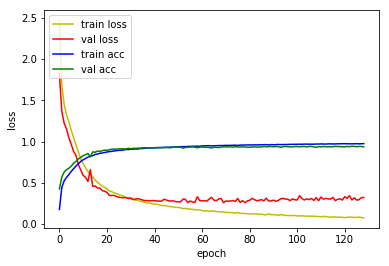

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2933 - acc: 0.9205
Loss: 0.2933371344567707 Accuracy: 0.9204569

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6475 - acc: 0.1171
Epoch 00001: val_loss improved from inf to 2.11950, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_7_conv_checkpoint/001-2.1195.hdf5
36805/36805 [==============================] - 99s 3ms/sample - loss: 2.6475 - acc: 0.1171 - val_loss: 2.1195 - val_acc: 0.3021
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9131 - acc: 0.3582
Epoch 00002: val_loss improved from 2.11950 to 1.43833, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_7_conv_checkpoint/002-1.4383.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.9129 - acc: 0.3582 - val_loss: 1.4383 - val_acc: 0.5409
Epoch 3/500
36800/36805 [============================>.] 

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3457 - acc: 0.8932
Epoch 00023: val_loss did not improve from 0.25115
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3457 - acc: 0.8932 - val_loss: 0.2533 - val_acc: 0.9308
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3294 - acc: 0.8994
Epoch 00024: val_loss did not improve from 0.25115
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3294 - acc: 0.8994 - val_loss: 0.2541 - val_acc: 0.9259
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3242 - acc: 0.9002
Epoch 00025: val_loss improved from 0.25115 to 0.22180, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_7_conv_checkpoint/025-0.2218.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.3243 - acc: 0.9002 - val_loss: 0.2218 - val_acc: 0.9357
Epoch 26/500
36800/36805 [============================>.] - ETA: 

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1800 - acc: 0.9418
Epoch 00049: val_loss did not improve from 0.16201
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1801 - acc: 0.9418 - val_loss: 0.1687 - val_acc: 0.9562
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1775 - acc: 0.9436
Epoch 00050: val_loss did not improve from 0.16201
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1775 - acc: 0.9436 - val_loss: 0.1772 - val_acc: 0.9522
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1750 - acc: 0.9440
Epoch 00051: val_loss did not improve from 0.16201
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1750 - acc: 0.9441 - val_loss: 0.1709 - val_acc: 0.9478
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1658 - acc: 0.9473
Epoch 00052: val_loss improved from 0.16201 to 0.16091, saving model to mod

36800/36805 [============================>.] - ETA: 0s - loss: 0.1098 - acc: 0.9642
Epoch 00077: val_loss did not improve from 0.14153
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1098 - acc: 0.9642 - val_loss: 0.1639 - val_acc: 0.9585
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1127 - acc: 0.9626
Epoch 00078: val_loss did not improve from 0.14153
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1128 - acc: 0.9626 - val_loss: 0.1728 - val_acc: 0.9583
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1074 - acc: 0.9646
Epoch 00079: val_loss did not improve from 0.14153
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1074 - acc: 0.9647 - val_loss: 0.1614 - val_acc: 0.9613
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1066 - acc: 0.9652
Epoch 00080: val_loss did not improve from 0.14153
36805/36805 [========================

Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0725 - acc: 0.9759
Epoch 00107: val_loss did not improve from 0.14153
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0725 - acc: 0.9759 - val_loss: 0.1635 - val_acc: 0.9595
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0731 - acc: 0.9755
Epoch 00108: val_loss did not improve from 0.14153
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0731 - acc: 0.9755 - val_loss: 0.1731 - val_acc: 0.9618
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0722 - acc: 0.9760
Epoch 00109: val_loss did not improve from 0.14153
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0722 - acc: 0.9760 - val_loss: 0.1831 - val_acc: 0.9597

1D_CNN_custom_conv_3_VGG_DO_075_DO_7_conv Model


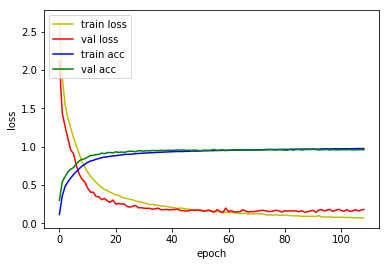

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1740 - acc: 0.9464
Loss: 0.1739721952522655 Accuracy: 0.94641745

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6644 - acc: 0.1058
Epoch 00001: val_loss improved from inf to 2.32311, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_8_conv_checkpoint/001-2.3231.hdf5
36805/36805 [==============================] - 103s 3ms/sample - loss: 2.6643 - acc: 0.1058 - val_loss: 2.3231 - val_acc: 0.2432
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0632 - acc: 0.3119
Epoch 00002: val_loss improved from 2.32311 to 1.46628, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_8_conv_checkpoint/002-1.4663.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 2.0631 - acc: 0.3119 - val_loss: 1.4663 - val_acc: 0.5674
Epoch 3/500
36800/36805 [============================>.

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2301 - acc: 0.9278
Epoch 00024: val_loss improved from 0.13954 to 0.13857, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_8_conv_checkpoint/024-0.1386.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.2301 - acc: 0.9278 - val_loss: 0.1386 - val_acc: 0.9590
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2277 - acc: 0.9283
Epoch 00025: val_loss did not improve from 0.13857
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.2277 - acc: 0.9283 - val_loss: 0.1426 - val_acc: 0.9592
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2174 - acc: 0.9312
Epoch 00026: val_loss did not improve from 0.13857
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.2174 - acc: 0.9312 - val_loss: 0.1408 - val_acc: 0.9583
Epoch 27/500
36800/36805 [============================>.] - ETA: 

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1086 - acc: 0.9649
Epoch 00052: val_loss did not improve from 0.10229
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1086 - acc: 0.9650 - val_loss: 0.1163 - val_acc: 0.9644
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1040 - acc: 0.9652
Epoch 00053: val_loss did not improve from 0.10229
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1039 - acc: 0.9652 - val_loss: 0.1043 - val_acc: 0.9704
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1020 - acc: 0.9669
Epoch 00054: val_loss improved from 0.10229 to 0.10223, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_8_conv_checkpoint/054-0.1022.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1020 - acc: 0.9669 - val_loss: 0.1022 - val_acc: 0.9665
Epoch 55/500
36800/36805 [============================>.] - ETA: 

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0627 - acc: 0.9797
Epoch 00081: val_loss did not improve from 0.09871
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0627 - acc: 0.9797 - val_loss: 0.1089 - val_acc: 0.9702
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0617 - acc: 0.9799
Epoch 00082: val_loss did not improve from 0.09871
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0617 - acc: 0.9799 - val_loss: 0.1111 - val_acc: 0.9720
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0617 - acc: 0.9792
Epoch 00083: val_loss did not improve from 0.09871
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0617 - acc: 0.9792 - val_loss: 0.1306 - val_acc: 0.9667
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0613 - acc: 0.9801
Epoch 00084: val_loss did not improve from 0.09871
36805/36805 [===========

Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0430 - acc: 0.9867
Epoch 00111: val_loss did not improve from 0.09871
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0429 - acc: 0.9867 - val_loss: 0.1351 - val_acc: 0.9727

1D_CNN_custom_conv_3_VGG_DO_075_DO_8_conv Model


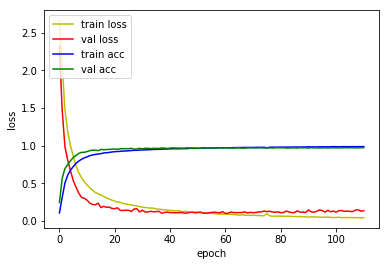

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1672 - acc: 0.9551
Loss: 0.16716184404844017 Accuracy: 0.9551402

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3769 - acc: 0.2215
Epoch 00001: val_loss improved from inf to 1.55977, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_9_conv_checkpoint/001-1.5598.hdf5
36805/36805 [==============================] - 108s 3ms/sample - loss: 2.3768 - acc: 0.2215 - val_loss: 1.5598 - val_acc: 0.5029
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4840 - acc: 0.5209
Epoch 00002: val_loss improved from 1.55977 to 1.05271, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_9_conv_checkpoint/002-1.0527.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.4840 - acc: 0.5209 - val_loss: 1.0527 - val_acc: 0.6744
Epoch 3/500
36800/36805 [============================>.

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1593 - acc: 0.9489
Epoch 00024: val_loss improved from 0.14579 to 0.13930, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_9_conv_checkpoint/024-0.1393.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1593 - acc: 0.9489 - val_loss: 0.1393 - val_acc: 0.9571
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1566 - acc: 0.9510
Epoch 00025: val_loss improved from 0.13930 to 0.12054, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_9_conv_checkpoint/025-0.1205.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1566 - acc: 0.9510 - val_loss: 0.1205 - val_acc: 0.9625
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1455 - acc: 0.9536
Epoch 00026: val_loss did not improve from 0.12054
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1455 - acc: 0.

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0515 - acc: 0.9827
Epoch 00053: val_loss did not improve from 0.12054
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0515 - acc: 0.9827 - val_loss: 0.1511 - val_acc: 0.9648
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0513 - acc: 0.9825
Epoch 00054: val_loss did not improve from 0.12054
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0513 - acc: 0.9825 - val_loss: 0.1428 - val_acc: 0.9711
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0542 - acc: 0.9821
Epoch 00055: val_loss did not improve from 0.12054
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0542 - acc: 0.9821 - val_loss: 0.1493 - val_acc: 0.9655
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0469 - acc: 0.9843
Epoch 00056: val_loss did not improve from 0.12054
36805/36805 [===========

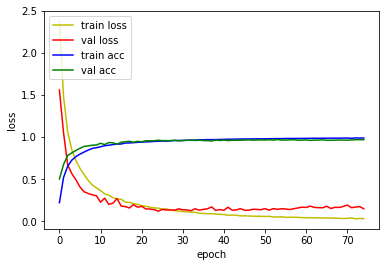

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1960 - acc: 0.9389
Loss: 0.19602461982429462 Accuracy: 0.9389408



In [10]:
for i in range(1, 10):
    model_name = '1D_CNN_custom_conv_3_VGG_DO_075_DO_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO_075_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)
    
    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_DO_075_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_DO_075_DO_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,396,624
Trainable params: 16,396,624
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 3s 611us/sample - loss: 2.0562 - acc

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.6308 - acc: 0.8706
Loss: 0.6307582460088522 Accuracy: 0.8706127

1D_CNN_custom_conv_3_VGG_DO_075_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_120 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_122 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_123 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_124 (Conv1D)       

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1672 - acc: 0.9551
Loss: 0.16716184404844017 Accuracy: 0.9551402

1D_CNN_custom_conv_3_VGG_DO_075_DO_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_162 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
conv1d_163 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_164 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_165 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_166 (Conv1D)      

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_DO_075_DO'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_DO_075_DO_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_96 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_97 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_98 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_99 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_100 (Conv1D)          (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_101 (Conv1D)        

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3421 - acc: 0.9227
Loss: 0.34211312928203175 Accuracy: 0.9227414

1D_CNN_custom_conv_3_VGG_DO_075_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_132 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_134 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_135 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_136 (Conv1D)      

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2165 - acc: 0.9624
Loss: 0.21652678627228772 Accuracy: 0.96240914
